# Drawing Sequence Model

## Import modules

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GRU, Embedding, Input, concatenate
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, roc_curve

Using TensorFlow backend.


## Preprocess

In [3]:
seq_data = pd.read_csv('data/draw-sequence.csv')

from data import preprocess
data = preprocess.preprocess('data/raw/CD_PD.mat')
label = data['diagnosis'].astype('int32')

# Fill NaN with -1
seq_data = seq_data.fillna(-1)
seq_data = seq_data.values[:,1:]

# Append non-time series feature
features = ['TMSE', 'age', 'gender']
n_features = len(features)
for feature in features:
    seq_data = np.c_[seq_data, data[feature]]

seq_len = 18

def split_data(seq_data, label):
    X_train, X_test, y_train, y_test = train_test_split(seq_data, label, test_size=0.2)

    # Reshape to 3D
    X_train_ts =  X_train[:,:seq_len].reshape((-1, seq_len, 1))
    X_test_ts = X_test[:,:seq_len].reshape((-1, seq_len, 1))
    X_train_nts = X_train[:,seq_len:].reshape((-1, n_features))
    X_test_nts = X_test[:,seq_len:].reshape((-1, n_features))

    return X_train_ts, X_test_ts, X_train_nts, X_test_nts, y_train, y_test

X_train_ts, X_test_ts, X_train_nts, X_test_nts, y_train, y_test = split_data(seq_data, label)

## Define Model

In [4]:
def get_model(seq_len, n_features):
    inputs_seq = Input(shape=(seq_len, 1))
    x = GRU(100, return_sequences=True)(inputs_seq)
    x = Dropout(0.2)(x)
    x = GRU(100, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Model(inputs=inputs_seq, outputs=x)

    inputs = Input(shape=(n_features, ))
    y = Dense(100, activation='relu')(inputs)
    y = Dropout(0.2)(y)
    y = Dense(100, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(100, activation='relu')(y)
    y = Dense(1)(y)
    y = Model(inputs=inputs, outputs=y)

    combined = concatenate([x.output, y.output])
    z = Dense(2)(combined)
    z = Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-5)
    optimizer=Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

get_model(seq_len, n_features).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 18, 100)      30600       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          400         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [5]:
model = get_model(seq_len, n_features)
model.fit([X_train_ts, X_train_nts], y_train, batch_size=32, 
    epochs=150, verbose=1, validation_data=([X_test_ts, X_test_nts], y_test))
model.evaluate([X_test_ts, X_test_nts], y_test, verbose=0)

Train on 156 samples, validate on 40 samples
Epoch 1/150
156/156 [==============================] - 2s 13ms/step - loss: 1.2949 - val_loss: 0.9582
Epoch 2/150
156/156 [==============================] - 0s 2ms/step - loss: 1.0613 - val_loss: 0.6742
Epoch 3/150
156/156 [==============================] - 0s 2ms/step - loss: 1.0096 - val_loss: 0.6206
Epoch 4/150
156/156 [==============================] - 0s 2ms/step - loss: 0.9455 - val_loss: 0.6579
Epoch 5/150
156/156 [==============================] - 0s 3ms/step - loss: 0.9920 - val_loss: 0.6643
Epoch 6/150
156/156 [==============================] - 0s 2ms/step - loss: 0.8664 - val_loss: 0.6405
Epoch 7/150
156/156 [==============================] - 0s 2ms/step - loss: 0.8713 - val_loss: 0.6243
Epoch 8/150
156/156 [==============================] - 0s 3ms/step - loss: 0.9118 - val_loss: 0.6223
Epoch 9/150
156/156 [==============================] - 0s 2ms/step - loss: 0.7817 - val_loss: 0.6231
Epoch 10/150
156/156 [=======================

0.6376371264457703

## Evaluation

40/40 [==============================] - 0s 699us/step
              precision    recall  f1-score   support

       No PD       0.67      0.95      0.78        21
          PD       0.90      0.47      0.62        19

   micro avg       0.72      0.72      0.73        40
   macro avg       0.78      0.71      0.70        40
weighted avg       0.78      0.72      0.71        40

[0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1
 0 0 1] [0.3353926  0.49104637 0.10876329 0.32680592 0.48741585 0.20387231
 0.32701322 0.3977126  0.15791415 0.7543449  0.5449723  0.531288
 0.3663482  0.4061655  0.38635552 0.7918627  0.34581992 0.19019084
 0.5459123  0.48695543 0.41675425 0.18064483 0.3822046  0.35904533
 0.41100544 0.5000828  0.29065952 0.67479914 0.16013458 0.30557132
 0.81705993 0.44584683 0.44889784 0.2411356  0.11200993 0.44386125
 0.44308442 0.8241167  0.26346624 0.579033  ]


0.725

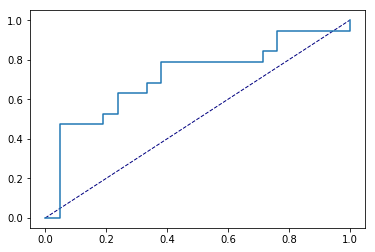

In [19]:
def eval_score(model, X_test_ts, X_test_nts, y_test, THRESHOLD = 0.5, report = False):
    y_pred = model.predict([X_test_ts, X_test_nts], batch_size=64, verbose=1).reshape(-1)
    y_pred_bool = np.where(y_pred < THRESHOLD, 0, 1)
    if report:
        print(classification_report(y_test, y_pred_bool, target_names=['No PD', 'PD']))
        print(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.plot(fpr, tpr)
        
    acc = accuracy_score(y_test, y_pred_bool)
    return acc

eval_score(model, X_test_ts, X_test_nts, y_test, report=True)

## Finding average score

In [28]:
scores = []
ITER_COUNT = 100
for i in range(ITER_COUNT):
    print('--------- %d try ---------' % (i + 1,))
    X_train_ts, X_test_ts, X_train_nts, X_test_nts, y_train, y_test = split_data()
    model = get_model(seq_len, n_features)
    model.fit([X_train_ts, X_train_nts], y_train, batch_size=32, epochs=150, verbose=0)
    acc = eval_score(model, X_test_ts, X_test_nts, y_test)
    scores.append(acc)
    print('Acc =', acc)
print('Min:', np.min(scores))
print('Max:', np.max(scores))
print('Avg:', np.mean(scores))
print('Std:', np.std(scores))

--------- 1 try ---------
40/40 [==============================] - 2s 41ms/step
Acc = 0.7
--------- 2 try ---------
40/40 [==============================] - 2s 52ms/step
Acc = 0.725
--------- 3 try ---------
40/40 [==============================] - 2s 41ms/step
Acc = 0.675
--------- 4 try ---------
40/40 [==============================] - 2s 43ms/step
Acc = 0.8
--------- 5 try ---------
40/40 [==============================] - 2s 46ms/step
Acc = 0.675
--------- 6 try ---------
40/40 [==============================] - 2s 49ms/step
Acc = 0.675
--------- 7 try ---------
40/40 [==============================] - 2s 49ms/step
Acc = 0.575
--------- 8 try ---------
40/40 [==============================] - 2s 53ms/step
Acc = 0.775
--------- 9 try ---------
40/40 [==============================] - 2s 60ms/step
Acc = 0.75
--------- 10 try ---------
40/40 [==============================] - 3s 69ms/step
Acc = 0.75
--------- 11 try ---------
40/40 [==============================] - 3s 73ms/step
Acc 

## Benchmarking

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


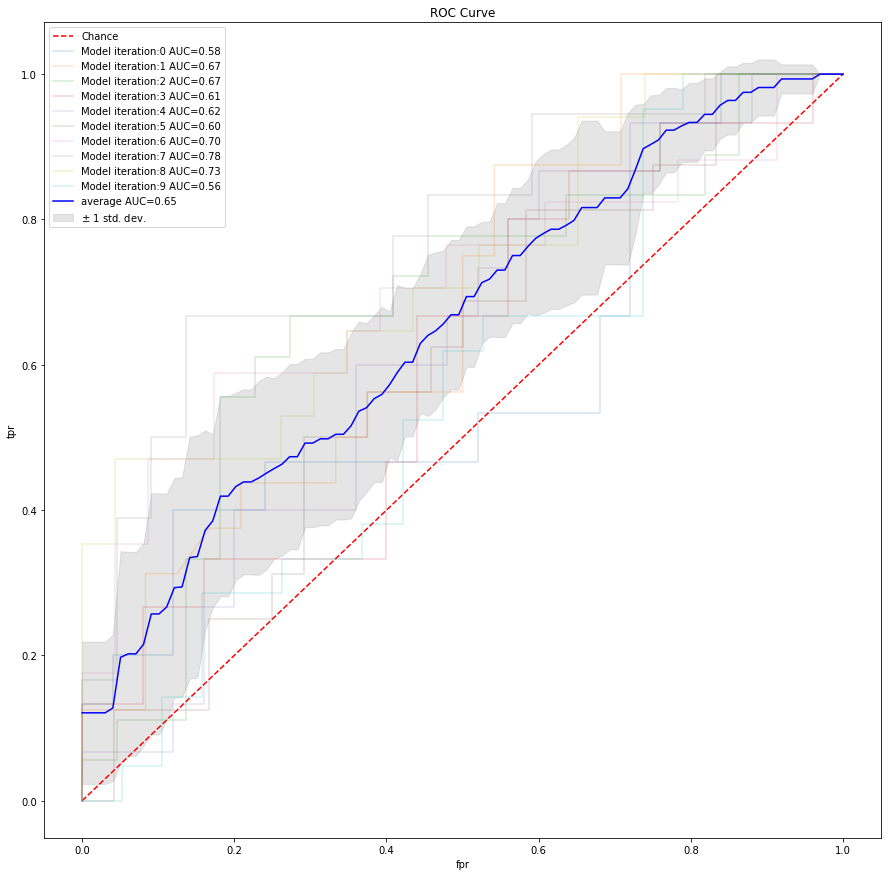

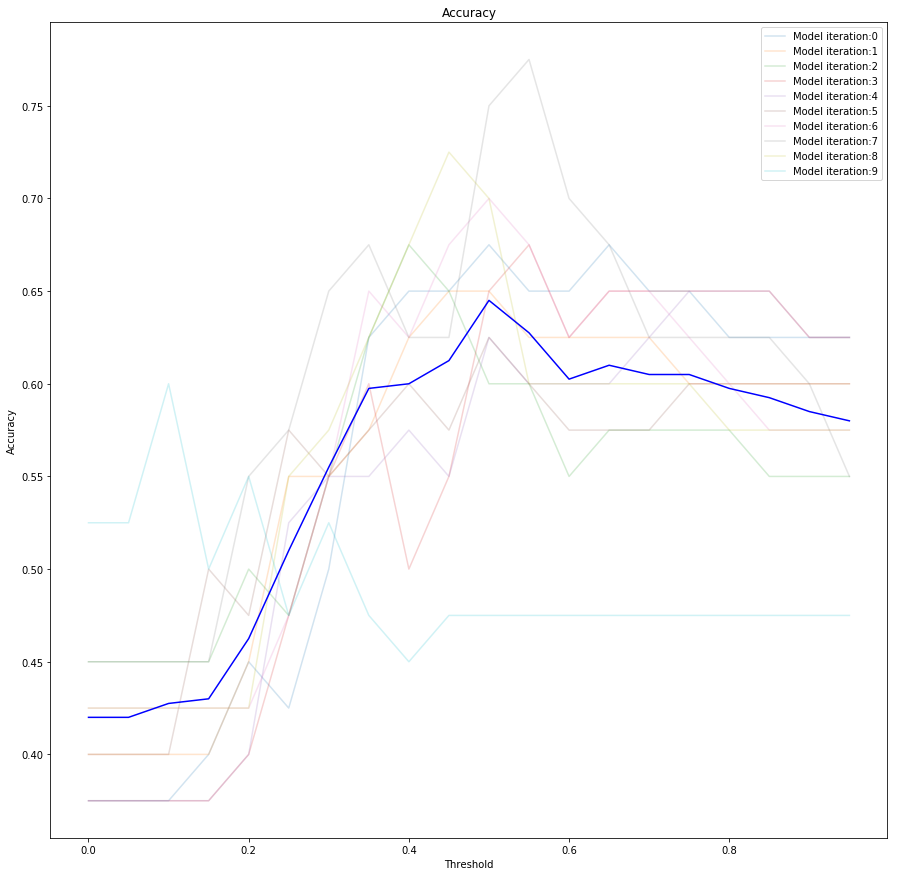

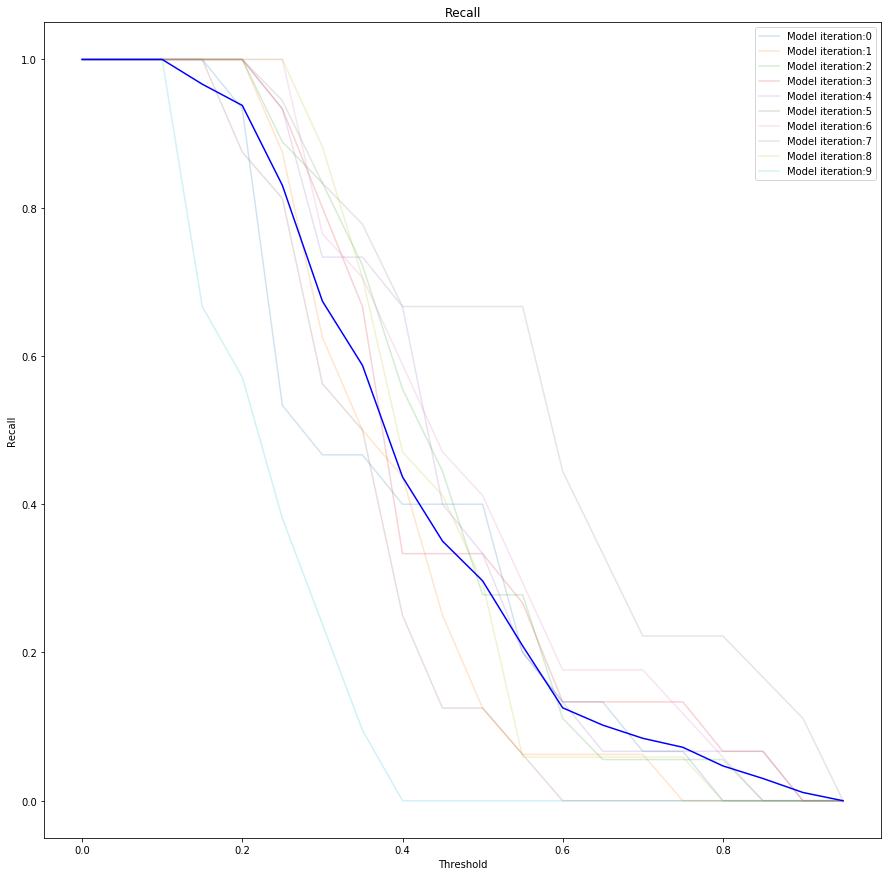

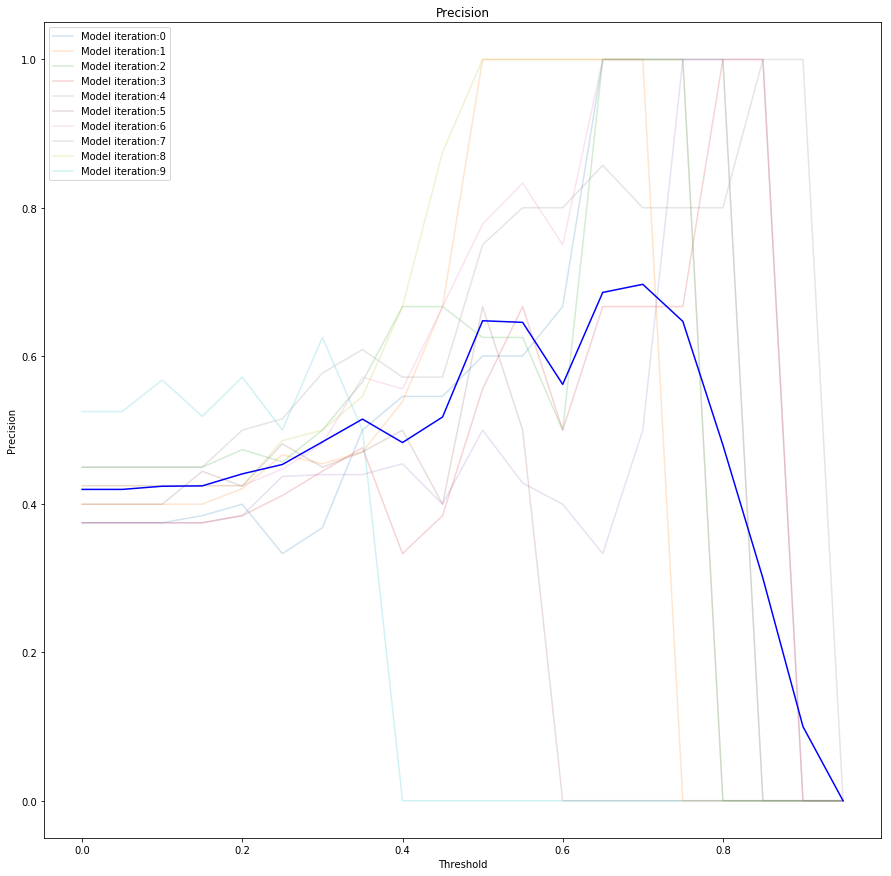

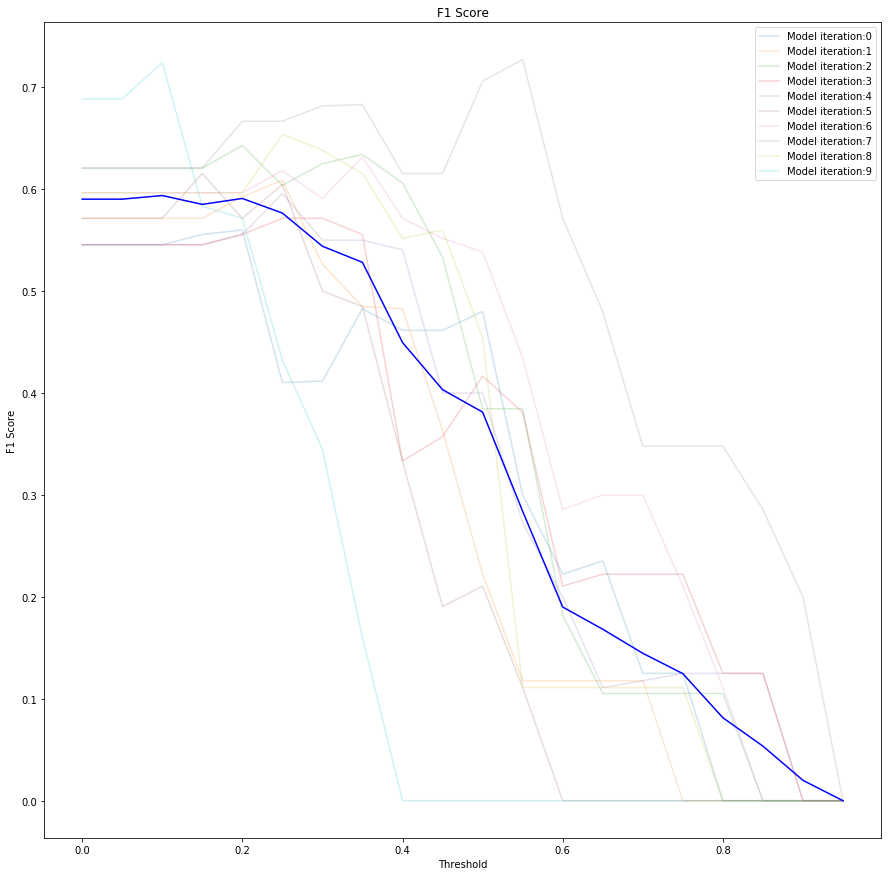

([<keras.engine.training.Model at 0x1695c5be0>,
 {'domain': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
         0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
         0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
         0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
         0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
         0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
         0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
         0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
         0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
         0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
         0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
         0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
         0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
         0.65656566, 0.66666667, 0.67676768, 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
import sys
sys.path.append('..')
from evaluation.evaluate import evaluate
import pickle as pkl  

def run_benchmark(get_split_data,
              get_model,
              data,
              label,
              k=1, 
              epochs=100,
              model_name='Model',
              verbose=0,
              figsize=(15,15)
             ):
    
    '''
    This function will run performance benchmark on the given model.
    Input:
        get_split_data : function to return sampled test train data. It must reture x_test, x_train, y_test, y_train in this
                        specified order.
        get_model : function to return a model to run benchmark on
        data : data numpy
        k : iteration to run the tests (higher k ~ more accurate to expected representation)
        epochs : number of epochs in training loop
        model_name (default='Model') : Name for the model, used in plotting ROC Curves
        verbose (default=0) : If not zero, then display benchmarking result/logs in each iteration
        
    Output:
        models : list of models which were generated & trained during the benchmarking
        plots : calculated plot data

    '''
    
    acc, rec, prec, f1 = [], [], [], []
    fp, tp, thresh = [], [], []
    mean_tp, _tp = [], []
    domain = np.linspace(0, 1, 100)
    aucs = []
    models = []
    histories = []

    thr_acc, thr_rec, thr_prec, thr_f1 = [], [], [], []
    thr_domain = np.arange(0, 1, 0.05)

    for i in range(k):
        if verbose:
            print('ITER:',i)
        X_train_ts, X_test_ts, X_train_nts, X_test_nts, y_train, y_test = get_split_data(data, label) #data should randomly shuffle
        #train & predict
        model = get_model(seq_len, n_features)
        history = model.fit([X_train_ts, X_train_nts], y_train, epochs=epochs, validation_data=([X_test_ts, X_test_nts], y_test),verbose=verbose)
        histories.append(history)
        models.append(model) #store model
        y_pred = model.predict([X_test_ts, X_test_nts])

        #metric eval for thresh = 0.5
        y2 = np.array(y_pred)
        y2[y2 >= 0.5] = 1
        y2[y2 < 0.5]  = 0
        t = evaluate(y_test, y2,verbose=verbose)

        #append the evaluation results to log
        acc.append(t[0])
        rec.append(t[1])
        prec.append(t[2])
        f1.append(t[3])

        #metric eval for vary thresh
        acc_temp, rec_temp, prec_temp, f1_temp = [], [], [], []
        for thr in thr_domain:
            y2 = np.array(y_pred)
            y2[y2 >= thr] = 1
            y2[y2 < thr] = 0
            t = evaluate(y_test, y2,verbose=verbose)
            acc_temp.append(t[0])
            rec_temp.append(t[1])
            prec_temp.append(t[2])
            f1_temp.append(t[3])
        thr_acc.append(acc_temp)
        thr_rec.append(rec_temp)
        thr_prec.append(prec_temp)
        thr_f1.append(f1_temp)
            
        #ROC for other thresh
        f, t, p = roc_curve(y_test, y_pred)
        _tp.append(np.interp(domain, f, t))

        #AUC
        a = auc(f, t)

        #logging
        fp.append(f)
        tp.append(t)
        thresh.append(p)
        aucs.append(a)
        
    if verbose:
        print('-----thresh=0.5--------')
        print('mean acc:',np.mean(acc))
        print('mean recall:',np.mean(rec))
        print('mean precision:',np.mean(prec))
        print('mean f1:',np.mean(f1))
        print('-----------------------')
        plt.title('Evaluation for 10 runs (thresh=0.5)')
        plt.plot(np.arange(k), acc, label='acc')
        plt.plot(np.arange(k), rec, label='recall')
        plt.plot(np.arange(k), prec,label='precision')
        plt.plot(np.arange(k), f1,  label='f1')
        plt.xlabel('iteration')
        plt.ylabel('score')
        plt.legend()
        plt.show()
        
    #Calculate mean and std of roc curve
    mean_tp = np.mean(_tp, axis=0)
    std_tp = np.std(_tp, axis=0)
    upper_tp = mean_tp + std_tp
    lower_tp = mean_tp - std_tp
    mean_auc = auc(domain, mean_tp)
    
    #ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    plt.figure(figsize=figsize)
    plt.title('ROC Curve')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot([0,1],[0,1],label='Chance', linestyle='dashed',color='red')
    
    #plot ROC Curve
    for i in range(k):
        plt.plot(fp[i], tp[i], label='%s iteration:%d AUC=%.2f' % (model_name,i,aucs[i]), alpha=0.2)
    plt.plot(domain, mean_tp, color='blue', alpha=1, label='average AUC=%.2f' % mean_auc)
    # plt.plot(domain, upper_tp, color='gray', alpha=0.1)
    # plt.plot(domain, lower_tp, color='gray', alpha=0.1)
    plt.fill_between(domain, upper_tp, lower_tp, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    plt.legend()
    plt.show()

    thr_acc = np.array(thr_acc)
    thr_rec = np.array(thr_rec)
    thr_prec = np.array(thr_prec)
    thr_f1 = np.array(thr_f1)

    def report_score_thr(thr_score, title):
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.xlabel('Threshold')
        plt.ylabel(title)
        for i in range(k):
            plt.plot(thr_domain, thr_score[i], label='%s iteration:%d' % (model_name,i), alpha=0.2)
        mean_thr = np.mean(thr_score, axis=0)
        plt.plot(thr_domain, mean_thr, color='blue', alpha=1)
        plt.legend()
        plt.show()

    report_score_thr(thr_acc, 'Accuracy')
    report_score_thr(thr_rec, 'Recall')
    report_score_thr(thr_prec, 'Precision')
    report_score_thr(thr_f1, 'F1 Score')
    plots = {'mean_tp':mean_tp, 'std_tp':std_tp, 'upper_tp':upper_tp, \
            'lower_tp':lower_tp, 'mean_auc':mean_auc, 'domain':domain,
    }

    results = {'y_pred': y_pred, 'histories':histories}

    return models, plots, results, { 'acc': thr_acc, 'rec': thr_rec, 'prec': thr_prec, 'f1': thr_f1 }

def save_log(path, log):
    pass
    # pkl.dump(os.path.join(path, log))

run_benchmark(split_data, get_model, seq_data, label, k=10)